In [16]:
import torch as tt
import torch.optim as oo
import torch.autograd as ag
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def Identity(x): return x
class Linear:
    r""" https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear """

    @staticmethod
    def layout(in_features , out_features): 
        return \
        {
            f'weight' : (out_features, in_features),  
            f'bias'   : (out_features,            ),  
        }

    @staticmethod
    @tt.no_grad()
    def initialize(params:dict, in_features, generator=None, weight='weight', bias='bias'):
        k = (1/in_features)**0.5
        params[weight].uniform_(-k, k, generator=generator)
        params[bias].uniform_(-k, k, generator=generator)


    @staticmethod
    def forward(params, weight, bias, input): return tt.matmul(input, params[weight].T) + params[bias]

    @staticmethod
    def forwardF(params, weight, bias, actF, input): return actF(tt.matmul(input, params[weight].T) + params[bias])

    @staticmethod
    def shapes(batch_size, in_features, out_features): 
        return dict(
            in_shape = (batch_size, in_features), 
            out_shape = (batch_size, out_features),
        )


class MLP:

    def __init__(self, input_size, layer_sizes, output_size, activations) -> None:
        n_layers = len(layer_sizes)+1
        assert len(activations)==n_layers
        members = dict(
            input_size = input_size,
            layer_sizes = layer_sizes,
            output_size = output_size,
            activations = activations,
            n_layers = n_layers,
            )
        for k,v in members.items(): 
            if hasattr(self, k):    print(f'[{__class__}] already has attribute [{k}], value [{v}] will be skipped!')
            else:                   setattr(self, k, v)

    def layout(self):
        layer_sizes = [self.input_size] + self.layer_sizes + [self.output_size]
        full_layout = {}
        for i in range(len(layer_sizes)-1):
            l = Linear.layout( in_features=layer_sizes[i],  out_features=layer_sizes[i+1],)
            full_layout[f'weight_{i}'] = l.pop('weight')
            full_layout[f'bias_{i}'] = l.pop('bias')
        return full_layout

    def forward(self, params, input): 
        y = input
        for i in range(self.n_layers):
            y = Linear.forwardF(params, f'weight_{i}', f'bias_{i}', self.activations[i], y)
        return y
    
    def __call__(self, params:dict, *args, **kwargs): return self.forward(params, *args, **kwargs)

    def init(self, params, generator=None):
        for i in range(self.n_layers): Linear.initialize(params, self.input_size, generator, f'weight_{i}', f'bias_{i}')
          
    def shapes(self, batch_size):
        return Linear.shapes(batch_size, self.input_size, self.output_size)

    def params(self, requires_grad=True, dtype=None, device=None) -> dict:
        r""" use to create a new dict of parameters from current layout """
        return {name : tt.zeros(size=size, dtype=dtype, device=device, requires_grad=requires_grad) for name, size in self.layout().items() }
        

# create MLP

In [18]:
batch_size = 5
input_size = 1
output_size = 1
dtype = tt.float32
lossF = tt.nn.MSELoss()

In [19]:
model = MLP(
    input_size=input_size, 
    layer_sizes=[64,64,64],
    output_size=output_size,
    activations=(tt.sigmoid, tt.tanh, tt.relu, Identity)
)


In [20]:
params = model.params(requires_grad=True, dtype=dtype)
for k,v in params.items():print(k, v.shape)
model.init(params)

weight_0 torch.Size([64, 1])
bias_0 torch.Size([64])
weight_1 torch.Size([64, 64])
bias_1 torch.Size([64])
weight_2 torch.Size([64, 64])
bias_2 torch.Size([64])
weight_3 torch.Size([1, 64])
bias_3 torch.Size([1])


In [21]:


# x = tt.rand((batch_size, input_size), dtype=dtype)
# y = tt.rand((batch_size, output_size), dtype=dtype)
# x.shape, y.shape, x, y
# p = model.forward(params, x)
# p.shape, p
# lossF = tt.nn.MSELoss()

# loss = lossF(p, y)
# loss

In [22]:
# opt = oo.SGD(params.values(), lr=0.001)
# opt

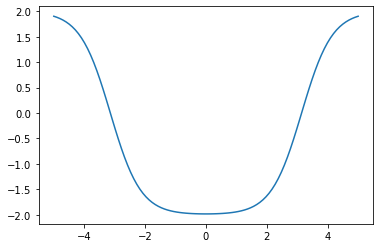

In [34]:
PHASE, AMP = np.pi, 2.0
X = tt.linspace(-5, 5, 100).to(dtype=dtype).unsqueeze(-1)
#Y = (tt.sin(X+PHASE)*AMP).to(dtype=dtype)
Y = ((tt.tanh(X+PHASE)*tt.tanh(X-PHASE)*AMP)).to(dtype=dtype)

plt.plot(X,Y)
dataset = tt.hstack((X,Y))


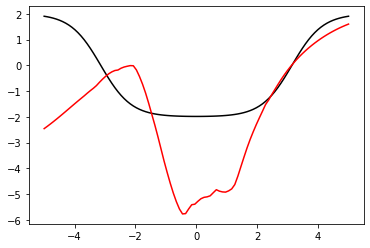

In [24]:
with tt.no_grad():
    P = model.forward(params, X)

plt.plot(X,Y, color='black')
plt.plot(X,P, color='red')

Data Split

In [35]:
num_clients = 5
# split dataset and assign to clients
total_input_size = dataset.shape[0]
from torch.utils.data import random_split, DataLoader

examples_per_client = total_input_size // num_clients
client_datasets = random_split(dataset, [min(i + examples_per_client, 
           total_input_size) - i for i in range(0, total_input_size, examples_per_client)])
clients = [('client_' + str(i), client_datasets[i]) for i in range(num_clients)]
clients[0][1]

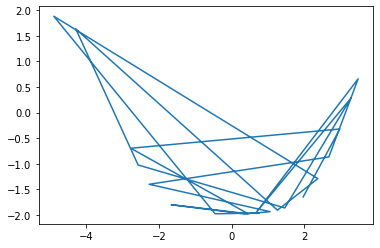

In [41]:
# ds = clients[0][1]
# xy = next(iter(DataLoader(ds, batch_size=len(ds))))
# x,y = xy[:,0], xy[:,1]
# plt.plot(x,y)

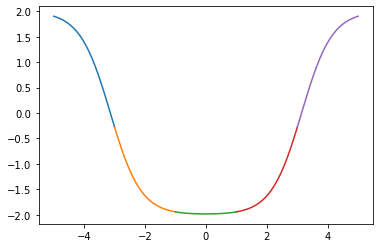

In [54]:
num_clients = 5
PHASE, AMP = np.pi, 2.0
clients = {}
lb, ub, total_size= -5, 5, 100
bound_size = int((ub-lb)/num_clients)
for i in range(num_clients):
    LB= lb + i * bound_size
    UB = LB + bound_size
    x = tt.linspace(LB, UB, int(total_size/num_clients)).to(dtype=dtype).unsqueeze(-1)
    # Y = (tt.sin(X+PHASE)*AMP).to(dtype=dtype)
    y = ((tt.tanh(x+PHASE)*tt.tanh(x-PHASE)*AMP)).to(dtype=dtype)

    plt.plot(x,y)
    clients[f'client_{i}'] = tt.hstack((x,y))
    # dataset = tt.hstack((X,Y))
    # plt.show()
# clients

In [13]:
lossL=[]

168.76101684570312
300.3501281738281
372.8114013671875
196.72482299804688
52.45661926269531


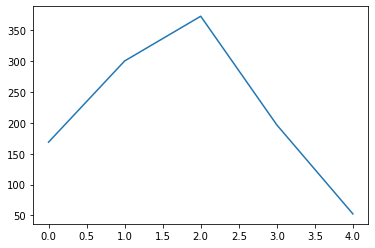

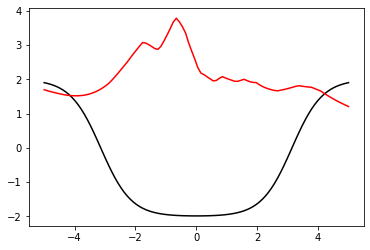

In [14]:

for _ in range(5):
    #opt.zero_grad()
    P = model.forward(params, X)
    loss = lossF(P, Y)
    #loss.backward()
    #opt.step()
    print(loss.item())
    lossL.append(loss.item())
    grads = ag.grad(loss, params.values())
    #print(grads)
    #input()
    with tt.no_grad():
        for p,g in zip(params.values(), grads): p-=(0.001*g)


plt.plot(lossL)
with tt.no_grad():
    P = model.forward(params, X)
plt.show()
plt.plot(X,Y, color='black')
plt.plot(X,P, color='red')